In [1]:
# import warnings
# warnings.filterwarnings('ignore') 

import os
import sys
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]


%matplotlib inline
import missingno as msno
import itertools
from IPython.display import display
from scipy.optimize import leastsq

from speclib.userActivityFunctions import getComdataMean, df2punchcard
from speclib.loaders import loadUserPhonenumberDict, getUserList, Useralias, loadUserParallel, dict2DataFrame, users2DataFrame
from speclib.plotting import looseAxesLimits, barSBS, countsOnBarPlot, plotPunchcard

Prepare to load users

In [2]:
userLst = getUserList() 
useralias = Useralias() 
userSpec = [(username, useralias[username], ('call', 'sms')) for username in userLst]
for el in userSpec[:10]:
    print(el)

('28b76d7b7879d364321f164df5169f', 'u0182', ('call', 'sms'))
('f41c375b5c87d3593b963b49a3f9a3', 'u1015', ('call', 'sms'))
('b600d2468831e0b3480a69af903dfc', 'u0778', ('call', 'sms'))
('dbbf1adb3264464838b938429d674b', 'u0933', ('call', 'sms'))
('3b6887b57d97d1ff1e1a674abfa5e3', 'u0256', ('call', 'sms'))
('972204b2d674a4681b2cb77e70c2b8', 'u0659', ('call', 'sms'))
('a94b118a62ebe7883a42d8966003b5', 'u0719', ('call', 'sms'))
('a71a2187b259601a2a98005fa20012', 'u0709', ('call', 'sms'))
('af1a0a02a3be070703128acde8d4b0', 'u0748', ('call', 'sms'))
('07be9cae12e7949a3ea091a234d30f', 'u0045', ('call', 'sms'))


In [3]:
users = loadUserParallel(userSpec, n=15) 

Turn loaded user data into a DateFrame

In [4]:
df = users2DataFrame(users, useralias, n=15) 
del users

/lscr_paper/allan/scripts/speclib/loaders.py:334: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df.sortlevel(level=0, inplace=True)


In [5]:
display(df.head(), df.tail()) 

body  duration  hour     id  \
user  comtype                               
u0001 call     NaN       0.0    15  61125   
      call     NaN       6.0    15  61126   
      call     NaN     675.0    17  61127   
      call     NaN       3.0    11  61642   
      call     NaN       4.0    11  61643   

                                                 number     timeint  \
user  comtype                                                         
u0001 call     b35fc61006d43cd9604fed5faa648f1dc78719f3  1379173762   
      call     b35fc61006d43cd9604fed5faa648f1dc78719f3  1379173787   
      call     fdcd4303a8e15cf230e4327e74ce128737759a8a  1379181010   
      call     2e01dcd41aa83506f975ac0d98574059a46a5792  1379244127   
      call     2e01dcd41aa83506f975ac0d98574059a46a5792  1379245412   

                        timestamp  type  weekday  
user  comtype                                     
u0001 call    2013-09-14 15:49:22     1        5  
      call    2013-09-14 15:49:47     1        5  
      call    2013-09-14 17:50:10     1        5  
      call    2013-09-15 11:22:07     2        6  
      call    2013-09-15 11:43:32     2        6

body  duration  hour  \
user  comtype                                                             
u1059 sms      543d1de77fa02cff0f31641df5eb025879d0e293       NaN    20   
      sms      3056ffb5d5a9ef7204879006259fba61f6f48db4       NaN    20   
      sms      6d2a58b373413326bb2bfb38cc536fc9458b4256       NaN    20   
      sms      24bb030818611eca379edad02b9194c9c55fc7e6       NaN    20   
      sms      9911b63ab8c570ed0e8d15b50c5b6a77bacc5e96       NaN    23   

                    id                                    number     timeint  \
user  comtype                                                                  
u1059 sms      2133003  959719a8d72dfea3dce5f72d09cf8363846a07bb  1397248912   
      sms      2133004  959719a8d72dfea3dce5f72d09cf8363846a07bb  1397249244   
      sms      2133005  959719a8d72dfea3dce5f72d09cf8363846a07bb  1397249592   
      sms      2133006  959719a8d72dfea3dce5f72d09cf8363846a07bb  1397249671   
      sms      2133007  959719a8d72dfea3dce5f72d09cf8363846a07bb  1397259949   

                        timestamp  type  weekday  
user  comtype                                     
u1059 sms     2014-04-11 20:41:52     2        4  
      sms     2014-04-11 20:47:24     1        4  
      sms     2014-04-11 20:53:12     2        4  
      sms     2014-04-11 20:54:31     1        4  
      sms     2014-04-11 23:45:49     2        4

Apparently there is messages with no recieving number…

In [6]:
idx = df.loc["u0645", "sms"].body == "cc0bf55fbc000c9ffa5ca348a1724744ae704ae0"

df.loc["u0645", "sms"][idx] 

,,body,duration,hour,id,number,timeint,timestamp,type,weekday
user,comtype,,,,,,,,,


# Some plotting 

Plot activity for all users calls and sms' side by side. Each category sums up to 1.

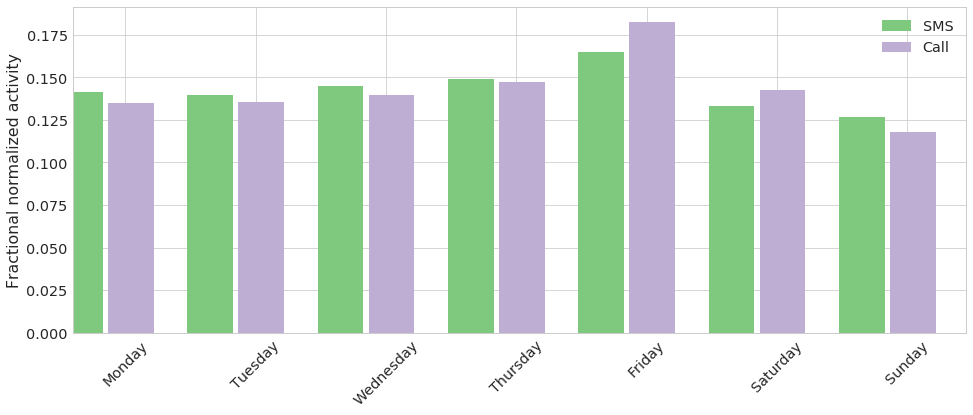

In [7]:
callWeek = df.xs('call', level=1).weekday.value_counts()
callWeek /= callWeek.sum()
smsWeek = df.xs('sms', level=1).weekday.value_counts()
smsWeek /= smsWeek.sum() 
fig, ax = plt.subplots(figsize=(16, 6)) 
d0 = {'y': smsWeek.sort_index(), 'label': 'SMS'} 
d1 = {'y': callWeek.sort_index(), 'label': 'Call'} 
barSBS(ax, d0, d1) 
ax.set_ylabel("Fractional normalized activity") 
ax.set_xticks(np.arange(0, 7) + 0.35) 
ax.set_xticklabels( ("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"), rotation=45 );
ax.set_xlim((-0.05, 6.8));

Index into a sublevel of the MultiIndex like so:

In [8]:
sms = df.xs('sms', level=1)
display(sms.head(), sms.tail()) 

,body,duration,hour,id,number,timeint,timestamp,type,weekday
user,,,,,,,,,
u0001,603bb2f76b6a69756d1e42b01237bf033cdc329,NaN,15,304929,,1379170969,2013-09-14 15:02:49,1,5
u0001,43a0627036534dd97535436c1c098cf2b0725756,NaN,15,304930,,1379173779,2013-09-14 15:49:39,1,5
u0001,78755c3492730e47cf2493a610fa7010d53af5f1,NaN,17,304931,6a5bfb684fe03aa7cf64664171cb1a0b04755a36,1379180229,2013-09-14 17:37:09,1,5
u0001,85c9018c1f0999e3009536ad369469ecd63b951b,NaN,19,304932,6a5bfb684fe03aa7cf64664171cb1a0b04755a36,1379186001,2013-09-14 19:13:21,2,5
u0001,22f7ec89aaaa2db370c86cc5d2f4c8d568845c54,NaN,19,304933,6a5bfb684fe03aa7cf64664171cb1a0b04755a36,1379186272,2013-09-14 19:17:52,1,5


,body,duration,hour,id,number,timeint,timestamp,type,weekday
user,,,,,,,,,
u1059,543d1de77fa02cff0f31641df5eb025879d0e293,NaN,20,2133003,959719a8d72dfea3dce5f72d09cf8363846a07bb,1397248912,2014-04-11 20:41:52,2,4
u1059,3056ffb5d5a9ef7204879006259fba61f6f48db4,NaN,20,2133004,959719a8d72dfea3dce5f72d09cf8363846a07bb,1397249244,2014-04-11 20:47:24,1,4
u1059,6d2a58b373413326bb2bfb38cc536fc9458b4256,NaN,20,2133005,959719a8d72dfea3dce5f72d09cf8363846a07bb,1397249592,2014-04-11 20:53:12,2,4
u1059,24bb030818611eca379edad02b9194c9c55fc7e6,NaN,20,2133006,959719a8d72dfea3dce5f72d09cf8363846a07bb,1397249671,2014-04-11 20:54:31,1,4
u1059,9911b63ab8c570ed0e8d15b50c5b6a77bacc5e96,NaN,23,2133007,959719a8d72dfea3dce5f72d09cf8363846a07bb,1397259949,2014-04-11 23:45:49,2,4


In [9]:
call = df.xs('call', level=1).hour.value_counts()
call /= call.sum()
sms = df.xs('sms', level=1).hour.value_counts()
sms /= sms.sum() 

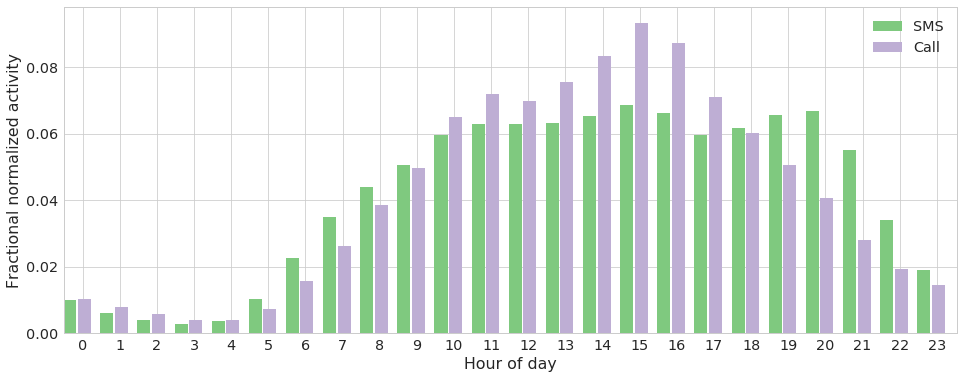

In [10]:
fig, ax = plt.subplots(figsize=(16, 6)) 
d0 = {'y': sms.sort_index(), 'label': 'SMS'} 
d1 = {'y': call.sort_index(), 'label': 'Call'} 
barSBS(ax, d0, d1) 
ax.set_ylabel("Fractional normalized activity") 
ax.set_xlabel("Hour of day") 
ax.set_xticks(np.arange(0, 24, dtype=np.int) + 0.35)
ax.set_xticklabels(["%d"%i for i in range(24)])
ax.set_xlim((-0.15, 23.89)); 

Count the number of times each uses calls or writes each unique phone number

In [11]:
if 'comFreq.pandasPickle' in os.listdir('.'):
    comFreq = pd.read_pickle('comFreq.pandasPickle')  # Computation is slow
else:
    comFreq = pd.DataFrame(index=df.index.get_level_values('user').unique(), columns=('sms', 'call'))
    comFreq.columns.name = 'comtype'
    for user in df.index.get_level_values('user').unique():
        for comtype in df.loc[user].index.unique():
            comFreq.loc[user, comtype] = df.loc[user, comtype].number.value_counts().values
    counterLambda = lambda x: 0 if np.any(pd.isnull(x)) else x.size
    comFreq['smsUnique'] = comFreq.sms.apply(counterLambda)
    comFreq['callUnique'] = comFreq.call.apply(counterLambda) 

In [12]:
comFreq.head() 

comtype,sms,call,smsUnique,callUnique
user,,,,
u0001,"[608, 417, 355, 355, 268, 228, 134, 124, 117, ...","[210, 158, 155, 123, 95, 78, 76, 41, 21, 19, 1...",57,90
u0002,"[458, 321, 293, 148, 101, 96, 73, 70, 63, 62, ...","[33, 27, 21, 17, 14, 14, 13, 13, 12, 12, 9, 8,...",151,156
u0003,"[285, 228, 165, 85, 67, 52, 51, 46, 44, 42, 32...","[490, 198, 80, 61, 60, 35, 27, 23, 22, 15, 14,...",60,89
u0004,"[7898, 486, 400, 373, 363, 349, 303, 280, 275,...","[187, 139, 139, 105, 61, 60, 60, 52, 49, 42, 4...",153,239
u0005,"[5245, 503, 341, 244, 241, 225, 108, 108, 89, ...","[273, 135, 114, 105, 78, 59, 54, 30, 23, 23, 2...",63,85


Plot the distribution

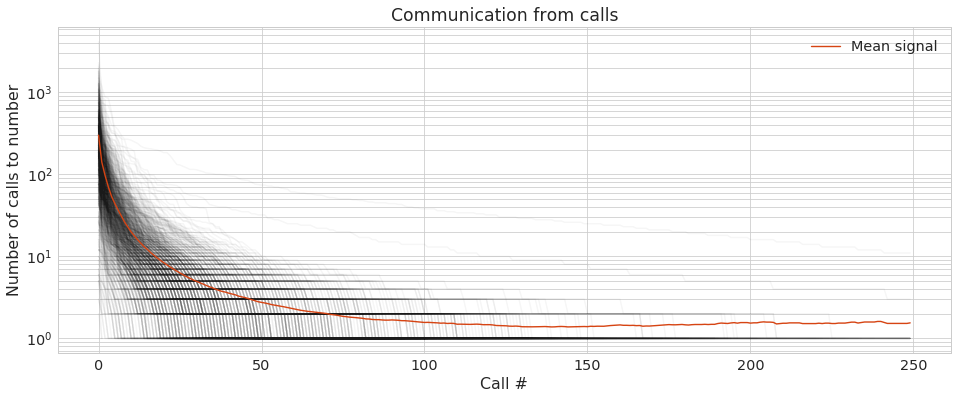

In [13]:
fig, ax = plt.subplots(figsize=(16,6)) 
nMaxEvents = 250
meanColor = '#d64413'
for user in comFreq.index:
    try:
        ax.semilogy(comFreq.loc[user].call[:nMaxEvents], 'k-', alpha=0.04)
    except TypeError:  # length-1 elements are apparently turned into floats, which isn't subscriptable
        ax.semilogy(comFreq.loc[user].call, 'k-', alpha=0.04)
ax.grid(which='minor')
ax.semilogy(getComdataMean(comFreq, 'call', 'callUnique')[:nMaxEvents], color=meanColor, label='Mean signal') 
ax.set_xlabel('Call #')
ax.set_ylabel("Number of calls to number")
ax.set_title("Communication from calls")
ax.legend() 

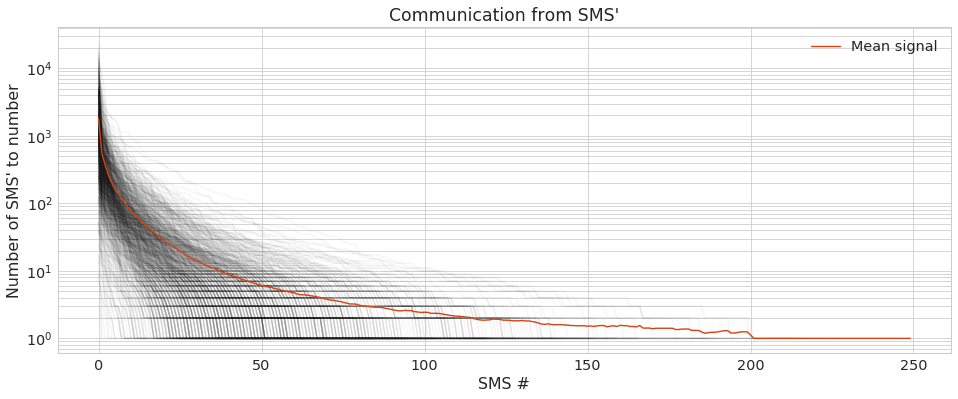

In [14]:
fig, ax = plt.subplots(figsize=(16,6)) 
nMaxEvents = 250
meanColor = '#d64413'
for user in comFreq.index:
    try:
        ax.semilogy(comFreq.loc[user].sms[:nMaxEvents], 'k-', alpha=0.04)
    except TypeError:  # length-1 elements are apparently turned into floats, which isn't subscriptable
        ax.semilogy(comFreq.loc[user].sms, 'k-', alpha=0.04)
ax.grid(which='minor')
ax.semilogy(getComdataMean(comFreq, 'sms', 'smsUnique')[:nMaxEvents], color=meanColor, label="Mean signal") 
ax.set_xlabel('SMS #')
ax.set_ylabel("Number of SMS' to number")
ax.set_title("Communication from SMS'")
ax.legend() 

Attempt a fit of the data, as I suspect it could be fittet well with a powerlaw.

While the fit did converge, I'm not convinced that it's better than my own guess… are the results weighted towards the lower end, or something like that? Or did my algorithm just converge on a local minima?

/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """
/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':
/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.


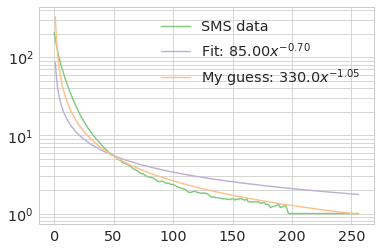

In [15]:
cut = 4
smsMean = getComdataMean(comFreq, 'sms', 'smsUnique')
smsMean = smsMean[cut:]
x = np.arange(len(smsMean), dtype=np.double) 
errfunc = lambda p, x, y: np.sqrt(y**2 - (p[0]*x**p[1])**2)
fit, _ = leastsq(errfunc, (85, -0.7), args=(x, smsMean))
fig, ax = plt.subplots()
ax.semilogy(x, smsMean, label='SMS data')
ax.semilogy(x, fit[0]*x**fit[1], label=r'Fit: $%.2f x^{%.2f}$' % tuple(fit)) 
ax.semilogy(x, 330*x**-1.05, label=r"My guess: $330.0 x^{-1.05}$")
ax.legend()
ax.grid(which='minor') 

# Clean the data

Check the min and max dates… seems some users didn't set the time on their phones

In [16]:
df.head() 

body  duration  hour     id  \
user  comtype                               
u0001 call     NaN       0.0    15  61125   
      call     NaN       6.0    15  61126   
      call     NaN     675.0    17  61127   
      call     NaN       3.0    11  61642   
      call     NaN       4.0    11  61643   

                                                 number     timeint  \
user  comtype                                                         
u0001 call     b35fc61006d43cd9604fed5faa648f1dc78719f3  1379173762   
      call     b35fc61006d43cd9604fed5faa648f1dc78719f3  1379173787   
      call     fdcd4303a8e15cf230e4327e74ce128737759a8a  1379181010   
      call     2e01dcd41aa83506f975ac0d98574059a46a5792  1379244127   
      call     2e01dcd41aa83506f975ac0d98574059a46a5792  1379245412   

                        timestamp  type  weekday  
user  comtype                                     
u0001 call    2013-09-14 15:49:22     1        5  
      call    2013-09-14 15:49:47     1        5  
      call    2013-09-14 17:50:10     1        5  
      call    2013-09-15 11:22:07     2        6  
      call    2013-09-15 11:43:32     2        6

In [17]:
df.head() 

body  duration  hour     id  \
user  comtype                               
u0001 call     NaN       0.0    15  61125   
      call     NaN       6.0    15  61126   
      call     NaN     675.0    17  61127   
      call     NaN       3.0    11  61642   
      call     NaN       4.0    11  61643   

                                                 number     timeint  \
user  comtype                                                         
u0001 call     b35fc61006d43cd9604fed5faa648f1dc78719f3  1379173762   
      call     b35fc61006d43cd9604fed5faa648f1dc78719f3  1379173787   
      call     fdcd4303a8e15cf230e4327e74ce128737759a8a  1379181010   
      call     2e01dcd41aa83506f975ac0d98574059a46a5792  1379244127   
      call     2e01dcd41aa83506f975ac0d98574059a46a5792  1379245412   

                        timestamp  type  weekday  
user  comtype                                     
u0001 call    2013-09-14 15:49:22     1        5  
      call    2013-09-14 15:49:47     1        5  
      call    2013-09-14 17:50:10     1        5  
      call    2013-09-15 11:22:07     2        6  
      call    2013-09-15 11:43:32     2        6

In [18]:
display(df.timestamp.min(), df.timestamp.max() ) 

Timestamp('1970-01-02 00:02:11')

Timestamp('2021-09-20 15:49:59')

Print aliases for all usesr which have events before 2013 and after 2015, along with min and max dates

In [19]:
for user in df.index.get_level_values('user').unique():
    if df.loc[user].timestamp.min().year < 2013 or df.loc[user].timestamp.max().year > 2015:
        print(user, df.loc[user].timestamp.min(), df.loc[user].timestamp.max(), sep="\t"*2)

u0048		2012-10-02 12:18:39		2014-10-09 23:08:58
u0055		1980-01-06 04:25:47		2015-03-21 16:46:15
u0080		2011-12-26 15:57:14		2014-10-11 13:13:09
u0090		2011-06-21 17:10:33		2015-01-09 18:54:17
u0118		1970-01-02 01:23:04		2014-10-08 20:18:54
u0298		2013-09-13 05:19:57		2021-09-20 15:49:59
u0318		2011-12-01 14:00:46		2014-10-29 10:32:52
u0393		2011-05-30 14:27:37		2014-09-09 20:49:40
u0622		2012-10-02 12:38:05		2015-03-18 18:27:08
u0635		1970-01-02 00:02:11		2014-11-23 15:11:49
u0660		1970-01-02 00:04:11		2014-11-20 14:53:51
u0764		2011-11-23 10:11:22		2015-03-08 02:00:11
u0778		2012-10-05 15:57:52		2015-03-23 13:10:44
u0786		2012-10-09 13:37:53		2014-08-27 13:49:09
u0912		2011-10-01 16:48:15		2015-03-19 16:39:17
u1022		2012-01-01 03:05:37		2015-02-02 17:32:06


Add a "year" column to the DataFrame, and plot a bar chart over the years

In [20]:
df['year'] = df.timestamp.apply(lambda x: x.year)

Seems like there was some activity as early as in 2011. 1970 is proably relating to a reset phone counting for Unix time 0, and will be removed along with events which "occured" in 1980 and 2021.

1970          6
1980          1
2011       6107
2012      29931
2013    1230146
2014    3326792
2015     329758
2021         13
Name: year, dtype: int64

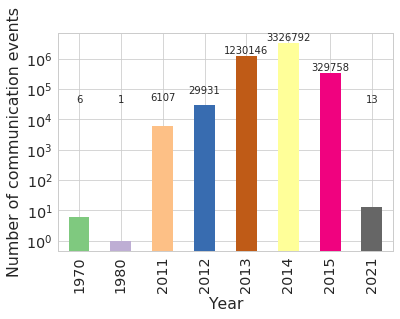

In [21]:
ax = df.year.value_counts().sort_index().plot.bar()  
ax.set_yscale('log')
# ax.grid(which='minor')
countsOnBarPlot(ax)
ax.set_ylabel("Number of communication events")
ax.set_xlabel("Year")
display(df.year.value_counts().sort_index())

Remove the faulty rows, and ensure that the number of removed rows correspond to the number of rows matched in the mask

In [22]:
rowsBefore = df.shape[0] 
mask = (df.year < 2011) | (df.year > 2016)
df = df[~mask]
rowsBefore - df.shape[0] == mask.sum() 

True

# Timebin users activity

Make a smaller dataset to experiment on... runtime tends to get large with full dataset

In [23]:
ul = ["u000%d" % i for i in range(1, 10)] 
ul 

['u0001',
 'u0002',
 'u0003',
 'u0004',
 'u0005',
 'u0006',
 'u0007',
 'u0008',
 'u0009']

In [24]:
dfs = df.loc[ul]  
dfs.index.get_level_values('user').unique() 

Index(['u0001', 'u0003', 'u0004', 'u0006', 'u0007', 'u0008', 'u0009'], dtype='object', name='user')

Check smaller version of dataset vs indexed version, where calls is indexed, and u0001 is chosen for convenience

In [25]:
dfs.head() 

body  duration  hour     id  \
user  comtype                               
u0001 call     NaN       0.0    15  61125   
      call     NaN       6.0    15  61126   
      call     NaN     675.0    17  61127   
      call     NaN       3.0    11  61642   
      call     NaN       4.0    11  61643   

                                                 number     timeint  \
user  comtype                                                         
u0001 call     b35fc61006d43cd9604fed5faa648f1dc78719f3  1379173762   
      call     b35fc61006d43cd9604fed5faa648f1dc78719f3  1379173787   
      call     fdcd4303a8e15cf230e4327e74ce128737759a8a  1379181010   
      call     2e01dcd41aa83506f975ac0d98574059a46a5792  1379244127   
      call     2e01dcd41aa83506f975ac0d98574059a46a5792  1379245412   

                        timestamp  type  weekday  year  
user  comtype                                           
u0001 call    2013-09-14 15:49:22     1        5  2013  
      call    2013-09-14 15:49:47     1        5  2013  
      call    2013-09-14 17:50:10     1        5  2013  
      call    2013-09-15 11:22:07     2        6  2013  
      call    2013-09-15 11:43:32     2        6  2013

In [26]:
dfs.loc[pd.IndexSlice[:, 'call'], :].loc['u0002'].head() 

KeyError: 'the label [u0002] is not in the [index]'

In [ ]:
ppc = df2punchcard(df) 


In [ ]:
punchcard = ppc[0:840:10, 0:3599:10]

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
pc = ax.pcolor(np.sqrt(punchcard), cmap=mpl.cm.afmhot)
fig.colorbar(pc)
ax.set_xlim(0, punchcard.shape[1])
ax.set_ylim(0, punchcard.shape[0]) 
ax.set_title("Sqrt of calls over all time, binned hourly, suspect it's buggy")
ax.set_xlabel('Hour since beinning of experiment')
ax.set_ylabel('Users')
ax.set_yticklabels([]);

In [ ]:
def timestamp2punchcard(timestamp):
    arr = np.zeros(24*7)
    for i, event in enumerate(timestamp):
        idx = 24*event.dayofweek + event.hour
        arr[idx] += 1
    return arr

users = df.index.get_level_values('user').unique()
nUsers = len(users)
punchcardCall = np.zeros((nUsers, 24*7))
punchcardSms = np.zeros((nUsers, 24*7))
oldPct = -1
for i, user in enumerate(users):
    newPct = round(i/len(users)*100)
    if newPct != oldPct and newPct % 10 == 0:
        print("{:.0f} %".format(newPct), end="\t")
        oldPct = newPct
    try:
        timestamp = df.loc[user, 'call'].timestamp
        punchcardCall[i, :] = timestamp2punchcard(timestamp)
    except KeyError as e:
        print("Error processing user %s (call)" % user, file=sys.stderr)
    try:
        timestamp = df.loc[user, 'sms'].timestamp
        punchcardSms[i, :] = timestamp2punchcard(timestamp)
    except KeyError as e:
        print("Error processing user %s (sms)" % user, file=sys.stderr)
    

In [ ]:
punchcardCallSorted = punchcardCall[np.argsort(punchcardCall.sum(axis=1))[::-1]]

In [ ]:
fig, ax = plotPunchcard(punchcardCall)
ax.set_title('User call activity aggregated hourly')

In [ ]:
fig, ax = plotPunchcard(punchcardCallSorted)
ax.set_title('User call activity aggregated hourly (sorted)')

In [ ]:
fig, ax = plotPunchcard(np.log10(punchcardCallSorted))
ax.set_title('Log of user call activity aggregated hourly (sorted)')

In [ ]:
fig, ax = plotPunchcard(punchcardCallSorted > 0)
ax.set_title('Binary user call activity aggregated hourly (sorted)')

In [ ]:
fig, ax = plotPunchcard(punchcardCall > 0)
ax.set_title('Binary user call activity aggregated hourly')